### Imports

In [2]:
import struct
import os
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import plotly.io as pio # themes
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from IPython.display import HTML
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.stats import binned_statistic
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
import time

sns.set_style("darkgrid")
sns.set(style='ticks', font_scale=1.3)
sns.set_palette("bright")
plt.rc('font', family='monospace')
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

idx = pd.IndexSlice
bgcolour = "rgb(15, 23, 42)"
plotly_template = pio.templates["plotly_dark"]

# Parameters
G = 2.9599e-4 # gravitational constant [AU^3 / M_solar * days^2]

### Reading & unpacking the binary data file

In [4]:
def process_data(simulation_run_folder):
     
    """
    This code first constructs the path to the out folder for the specific simulation run. It then uses os.listdir to get a list of filenames in the out folder, and filters the list to only include filenames that end with ".bin". The resulting list of snapshot filenames is then sorted, so that the snapshots are processed in order.
    """
     
    snapshot_folder = os.path.join("out", simulation_run_folder)

    snapshot_filenames = []
    for filename in os.listdir(snapshot_folder):
        if filename.endswith(".bin"):
            snapshot_filenames.append(os.path.join(snapshot_folder, filename))

    snapshot_filenames.sort()

    """ 
    This code reads the header data from the binary file - in most cases, we only need to read the first snapshot, since the header data is the same for all snapshots. We will implement a way to read the header data from any snapshot file.
    """

    filename = snapshot_filenames[0]
    with open(filename, 'rb') as f:
        header_dtype = np.dtype([('N', np.int32),
                                ('current_time', np.float32),
                                ('delta_time', np.float32),
                                ('softening_factor', np.float32),
                                ('mass_seed', np.uint32),
                                ('position_seed', np.uint32),
                                ('velocity_seed', np.uint32)])
        
        header = np.frombuffer(f.read(header_dtype.itemsize), header_dtype)

    n_bodies = header['N'][0]
    softening_factor = header['softening_factor'][0]
    mass_seed = header['mass_seed'][0]
    position_seed = header['position_seed'][0]
    velocity_seed = header['velocity_seed'][0]
    total_snapshots = len(snapshot_filenames)

    print("n_bodies: ", n_bodies)
    # print("softening_factor: ", softening_factor)
    # print("total_snapshots: ", total_snapshots)
    # print(f'mass_seed: {mass_seed} | position_seed: {position_seed} | velocity_seed: {velocity_seed}')
    
    """
    This code reads each binary snapshot file in turn using `np.frombuffer`, and returns the data as a numpy array. The data is then reshaped to the correct dimensions, and the mass, position, velocity, and force data is extracted. 
    """

    mass = np.zeros((total_snapshots, n_bodies), dtype=np.float32)
    pos = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    vel = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    acc = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    current_time = np.zeros((total_snapshots,), dtype=np.float32)
    delta_time = np.zeros((total_snapshots,), dtype=np.float32)

    # for index, snapshot_filename in enumerate(snapshot_filenames):
    #     with open(snapshot_filename, "rb") as f:
    #         header = np.frombuffer(f.read(header_dtype.itemsize), header_dtype)
    #         current_time[index] = header['current_time'][0]
    #         delta_time[index] = header['delta_time'][0]

    #         snapshot = np.frombuffer(f.read(), dtype=np.float32)
    #         snapshot = snapshot.reshape((n_bodies, 10))

    #         mass[index, :] = snapshot[:, 0]
    #         pos[index, :, :] = snapshot[:, 1:4]
    #         vel[index, :, :] = snapshot[:, 4:7]
    #         acc[index, :, :] = snapshot[:, 7:10]

    """
    Read only the last snapshot
    """

    snapshot_filename = snapshot_filenames[-1]  # get last filename

    with open(snapshot_filename, "rb") as f:
        header = np.frombuffer(f.read(header_dtype.itemsize), header_dtype)
        current_time = header['current_time'][0]
        delta_time = header['delta_time'][0]

        snapshot = np.frombuffer(f.read(), dtype=np.float32)
        snapshot = snapshot.reshape((n_bodies, 10))

        mass = snapshot[:, 0]
        pos = snapshot[:, 1:4]
        vel = snapshot[:, 4:7]
        acc = snapshot[:, 7:10]

    total_time = current_time
    print(f'total_time: {total_time:.2f} days | {total_time/365.25:.4f} yrs')

    """ 
    This code extracts the mass, position, velocity, and force data from the numpy arrays, and stores it in a pandas DataFrame. The DataFrame is then returned, along with the header data.
    """

    # df_list = []
    # for i in range(n_bodies):
    #     data = {
    #         "mass": mass[:, i],
    #         "x": pos[:, i, 0],
    #         "y": pos[:, i, 1],
    #         "z": pos[:, i, 2],
    #         "vx": vel[:, i, 0],
    #         "vy": vel[:, i, 1],
    #         "vz": vel[:, i, 2],
    #         "fx": acc[:, i, 0],
    #         "fy": acc[:, i, 1],
    #         "fz": acc[:, i, 2],
    #         "current_time": current_time,
    #         "delta_time": delta_time
    #     }
    #     df_list.append(pd.DataFrame(data))

    # df = pd.concat(df_list, axis=1, keys=["{}".format(i) for i in range(n_bodies)])

    df_list = []
    for i in range(n_bodies):
        data = {
            "mass": mass[i],
            "x": pos[i, 0],
            "y": pos[i, 1],
            "z": pos[i, 2],
            "vx": vel[i, 0],
            "vy": vel[i, 1],
            "vz": vel[i, 2],
            "fx": acc[i, 0],
            "fy": acc[i, 1],
            "fz": acc[i, 2],
            "current_time": current_time,
            "delta_time": delta_time
        }
        df_list.append(pd.DataFrame(data, index=[0]))

    df = pd.concat(df_list, axis=1, keys=["{}".format(i) for i in range(n_bodies)])

    """
    This code creates a numpy array that contains the snapshot index and the current time for each snapshot. This array is returned along with the DataFrame, header data, and other useful information.
    """

    # snapshot_indices = np.arange(total_snapshots)
    # current_time_array = df[("0", "current_time")].values
    # time_arr = np.column_stack((snapshot_indices, current_time_array))
    # delta_time_arr = df[("0", "delta_time")].values

    snapshot_indices = np.array([len(snapshot_filenames) - 1])  # only the last snapshot
    current_time_array = df[("0", "current_time")].values
    time_arr = np.column_stack((snapshot_indices, current_time_array))
    delta_time_arr = df[("0", "delta_time")].values

    total_snapshots = 1  # only the last snapshot

    return df, time_arr, current_time_array, delta_time_arr, n_bodies, softening_factor, total_snapshots, total_time


In [5]:
def process_single_pair(pair, data, time_arr, total_snapshots):
    i, j = pair

    x  = data.loc[:,idx[:,'x']].groupby(level=0, axis=1).sum()
    y  = data.loc[:,idx[:,'y']].groupby(level=0, axis=1).sum()
    z  = data.loc[:,idx[:,'z']].groupby(level=0, axis=1).sum()
    vx = data.loc[:,idx[:,'vx']].groupby(level=0, axis=1).sum()
    vy = data.loc[:,idx[:,'vy']].groupby(level=0, axis=1).sum()
    vz = data.loc[:,idx[:,'vz']].groupby(level=0, axis=1).sum()
    fx = data.loc[:,idx[:,'fx']].groupby(level=0, axis=1).sum()
    fy = data.loc[:,idx[:,'fy']].groupby(level=0, axis=1).sum()
    fz = data.loc[:,idx[:,'fz']].groupby(level=0, axis=1).sum()
    m  = data.loc[:,idx[:,'mass']].groupby(level=0, axis=1).sum()

    r1 = np.sqrt(x.iloc[:,i]**2 + y.iloc[:,i]**2 + z.iloc[:,i]**2)
    r2 = np.sqrt(x.iloc[:,j]**2 + y.iloc[:,j]**2 + z.iloc[:,j]**2)

    v1 = np.sqrt(vx.iloc[:,i]**2 + vy.iloc[:,i]**2 + vz.iloc[:,i]**2)
    v2 = np.sqrt(vx.iloc[:,j]**2 + vy.iloc[:,j]**2 + vz.iloc[:,j]**2)
    
    m1, m2 = m.iloc[:,i], m.iloc[:,j]

    # Calculate centre of mass position & velocity
    r_com = (m1 * r1 + m2 * r2) / (m1 + m2)
    v_com = (m1 * v1 + m2 * v2) / (m1 + m2)

    # Apply centre of mass correction to relative position & velocity
    r1 -= r_com; r2 -= r_com
    v1 -= v_com; v2 -= v_com

    KE = 0.5 * m1 * v1**2 + 0.5 * m2 * v2**2
    GPE = -G * m1 * m2 / (r1 - r2)**2

    total_energy = KE + GPE

    pair_results = []
    for k in range(total_snapshots):
        if total_energy.iloc[k] < 0:  # Check if the pair is bound
            # Check if the body 'i' is more bound to 'j' than any previous 'j' bodies
            i_other_pair_energy = [
                (m, m1.iloc[k] * m2.iloc[k] * ((vx.iloc[k, m-i-1] - vx.iloc[k, i])**2 + (vy.iloc[k, m-i-1] - vy.iloc[k, i])**2 + (vz.iloc[k, m-i-1] - vz.iloc[k, i])**2) / 2 - G * m1.iloc[k] * m2.iloc[k] / np.abs(r1.iloc[k] - r2.iloc[k])**2)
                for m in range(i + 1, j)
            ]
            if all(energy < total_energy.iloc[k] for _, energy in i_other_pair_energy):
                pair_results.append((
                    k,
                    (i, j),
                    time_arr[k],
                    (m1.iloc[k], m2.iloc[k]),
                    ((x.iloc[k, i], y.iloc[k, i], z.iloc[k, i]), (x.iloc[k, j], y.iloc[k, j], z.iloc[k, j])),
                    ((vx.iloc[k, i], vy.iloc[k, i], vz.iloc[k, i]), (vx.iloc[k, j], vy.iloc[k, j], vz.iloc[k, j])),
                    ((fx.iloc[k, i], fy.iloc[k, i], fz.iloc[k, i]), (fx.iloc[k, j], fy.iloc[k, j], fz.iloc[k, j])),
                ))

    return pair_results

In [11]:
from concurrent.futures import ProcessPoolExecutor, as_completed

def find_bound_pairs(data, total_snapshots, n_bodies, time_arr):
    pairs = [[]for b in range(total_snapshots)]  # Initialize empty array for pairs
    pair_times = [[] for b in range(total_snapshots)]  # Initialize empty array for pair times
    masses = [[] for b in range(total_snapshots)]  # Initialize empty array for pair masses
    positions = [[] for b in range(total_snapshots)]  # Initialize empty array for pair positions
    velocities = [[] for b in range(total_snapshots)]  # Initialize empty array for pair velocities
    forces = [[] for b in range(total_snapshots)]  # Initialize empty array for pair forces

    # pairs = []  # Initialize empty array for pairs
    # pair_times = []  # Initialize empty array for pair times
    # masses = []  # Initialize empty array for pair masses
    # positions = []  # Initialize empty array for pair positions
    # velocities = []  # Initialize empty array for pair velocities
    # forces = []  # Initialize empty array for pair forces


    # Start of the new ThreadPoolExecutor block
    with ProcessPoolExecutor() as executor:
        futures = []
        for i in range(0, n_bodies - 1):
            for j in range(i + 1, n_bodies):
                future = executor.submit(process_single_pair, (i, j), data, time_arr, total_snapshots)
                futures.append(future)

        # Collect results
        results = [future.result() for future in as_completed(futures)]
        
    # Process results and store them in the data dictionary
    for pair_results in results:
        for result in pair_results:
            k, pair, pair_time, pair_mass, pair_position, pair_velocity, pair_force = result

            # Check for duplicate pairs
            i, j = pair
            reverse_pair = (j, i)

            if reverse_pair not in pairs[k]:
                pairs[k].append(pair)
                pair_times[k].append(pair_time)
                masses[k].append(pair_mass)
                positions[k].append(pair_position)
                velocities[k].append(pair_velocity)
                forces[k].append(pair_force)

    data['pairs'] = pairs
    data['pair_times'] = pair_times
    data['masses'] = masses
    data['positions'] = positions
    data['velocities'] = velocities
    data['forces'] = forces

    # Compute the binary fraction for each timestep
    binary_fraction = [len(pairs[k]) / n_bodies for k in range(total_snapshots)]
    data['binary_fraction'] = binary_fraction

    # Compute the mass fraction for each timestep
    m = data.loc[:,idx[:,'mass']].groupby(level=0, axis=1).sum()
    # total_mass = m.cumsum(axis=1).iloc[:,-1]
    total_mass = np.array(m.cumsum(axis=1).iloc[:, -1], dtype=np.float64)

    pair_mass_sum = [[sum(mass_pair) for mass_pair in mass_pairs] for mass_pairs in data['masses']]

    mass_fraction = []
    for k in range(total_snapshots):
        mass_fraction_k = min(1, np.sum(pair_mass_sum[k]) / total_mass[k])
        mass_fraction.append(mass_fraction_k)

    data['mass_fraction'] = mass_fraction
    
    return data

In [7]:
def calculate_bound_pairs(simulation_run_folder):
    df, time_arr, current_time_array, delta_time_arr, n_bodies, softening_factor, total_snapshots, total_time = process_data(simulation_run_folder)
    bound_pairs_df = find_bound_pairs(df, total_snapshots, n_bodies, current_time_array)

    return bound_pairs_df

In [24]:
SIMULATION_BASE = "n-10-fil-parallel"

# Set the directory where the folders are located
directory = "out"
# Get the list of all folders in the directory
all_folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
# Filter the folders based on the SIMULATION_BASE name
simulation_run_folders = [folder for folder in all_folders if folder.startswith(SIMULATION_BASE)]
print(simulation_run_folders)

binary_data_list = []

for i, simulation_run_folder in enumerate(tqdm(simulation_run_folders, desc="Processing simulation runs")):

    print(f"Processing {simulation_run_folder} ({i+1}/{len(simulation_run_folders)})")

    bound_pairs_df = calculate_bound_pairs(simulation_run_folder)
    
    bound_pairs_df['num_pairs']       = bound_pairs_df['pairs'].apply(lambda row: sum(1 for _ in row))
    bound_pairs_df['pair_times']      = bound_pairs_df['pair_times'].apply(lambda row: np.array(row))
    # remove duplicate entries in pair times list and remove square bracket list/array bit
    bound_pairs_df['pair_times']      = bound_pairs_df['pair_times'].apply(lambda row: np.unique(row)[0] if len(np.unique(row)) == 1 else np.unique(row))
    bound_pairs_df['binary_fraction'] = bound_pairs_df['binary_fraction'].apply(lambda row: np.array(row))
    bound_pairs_df['mass_fraction']   = bound_pairs_df['mass_fraction'].apply(lambda row: np.array(row))
    # bound_pairs_df['mass_fraction'] = bound_pairs_df['mass_fraction'].apply(lambda row: row[0] if len(row) == 1 else row)
    
    # remove square brackets and lists from mass_fraction column so the objects become numpy float64
    

    # binary_data_list.append(bound_pairs_df[['pairs', 'num_pairs', 'pair_times', 'binary_fraction', 'mass_fraction', 'masses', 'positions', 'velocities', 'forces']].copy())
    binary_data_list.append(bound_pairs_df[['pairs', 'num_pairs', 'pair_times', 'binary_fraction', 'mass_fraction', 'masses']].copy())

    # binary_data_list.append(bound_pairs_df[['num_pairs', 'pair_times']].copy())

binary_data = pd.concat(binary_data_list, ignore_index=True)
binary_data.to_pickle(f'{SIMULATION_BASE}-final_binary_data.pkl')

['n-10-fil-parallel-027', 'n-10-fil-parallel-033', 'n-10-fil-parallel-007', 'n-10-fil-parallel-059', 'n-10-fil-parallel-018', 'n-10-fil-parallel-015', 'n-10-fil-parallel-023', 'n-10-fil-parallel-084', 'n-10-fil-parallel-032', 'n-10-fil-parallel-085', 'n-10-fil-parallel-071', 'n-10-fil-parallel-036', 'n-10-fil-parallel-091', 'n-10-fil-parallel-010', 'n-10-fil-parallel-060', 'n-10-fil-parallel-088', 'n-10-fil-parallel-002', 'n-10-fil-parallel-099', 'n-10-fil-parallel-051', 'n-10-fil-parallel-074', 'n-10-fil-parallel-092', 'n-10-fil-parallel-025', 'n-10-fil-parallel-012', 'n-10-fil-parallel-034', 'n-10-fil-parallel-098', 'n-10-fil-parallel-006', 'n-10-fil-parallel-093', 'n-10-fil-parallel-004', 'n-10-fil-parallel-053', 'n-10-fil-parallel-058', 'n-10-fil-parallel-052', 'n-10-fil-parallel-040', 'n-10-fil-parallel-001', 'n-10-fil-parallel-048', 'n-10-fil-parallel-030', 'n-10-fil-parallel-063', 'n-10-fil-parallel-013', 'n-10-fil-parallel-066', 'n-10-fil-parallel-056', 'n-10-fil-parallel-054',

Processing simulation runs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing n-10-fil-parallel-027 (1/100)
n_bodies:  10
total_time: 36524116.00 days | 99997.5797 yrs
Processing n-10-fil-parallel-033 (2/100)
n_bodies:  10
total_time: 36524948.00 days | 99999.8576 yrs
Processing n-10-fil-parallel-007 (3/100)
n_bodies:  10
total_time: 36524540.00 days | 99998.7406 yrs
Processing n-10-fil-parallel-059 (4/100)
n_bodies:  10
total_time: 36524868.00 days | 99999.6386 yrs
Processing n-10-fil-parallel-018 (5/100)
n_bodies:  10
total_time: 36524240.00 days | 99997.9192 yrs
Processing n-10-fil-parallel-015 (6/100)
n_bodies:  10
total_time: 36523844.00 days | 99996.8350 yrs
Processing n-10-fil-parallel-023 (7/100)
n_bodies:  10
total_time: 36524324.00 days | 99998.1492 yrs
Processing n-10-fil-parallel-084 (8/100)
n_bodies:  10
total_time: 36524640.00 days | 99999.0144 yrs
Processing n-10-fil-parallel-032 (9/100)
n_bodies:  10
total_time: 36524780.00 days | 99999.3977 yrs
Processing n-10-fil-parallel-085 (10/100)
n_bodies:  10
total_time: 36524504.00 days | 9999

/tmp/ipykernel_185766/2029824388.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  (m, m1.iloc[k] * m2.iloc[k] * ((vx.iloc[k, m-i-1] - vx.iloc[k, i])**2 + (vy.iloc[k, m-i-1] - vy.iloc[k, i])**2 + (vz.iloc[k, m-i-1] - vz.iloc[k, i])**2) / 2 - G * m1.iloc[k] * m2.iloc[k] / np.abs(r1.iloc[k] - r2.iloc[k])**2)
/tmp/ipykernel_185766/2029824388.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  (m, m1.iloc[k] * m2.iloc[k] * ((vx.iloc[k, m-i-1] - vx.iloc[k, i])**2 + (vy.iloc[k, m-i-1] - vy.iloc[k, i])**2 + (vz.iloc[k, m-i-1] - vz.iloc[k, i])**2) / 2 - G * m1.iloc[k] * m2.iloc[k] / np.abs(r1.iloc[k] - r2.iloc[k])**2)
/tmp/ipykernel_185766/2029824388.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  (m, m1.iloc[k] * m2.iloc[k] * ((vx.iloc[k, m-i-1] - vx.iloc[k, i])**2 + (vy.iloc[k, m-i-1] - vy.iloc[k, i])**2 + (vz.iloc[k, m-i-1] - vz.iloc[k, i])**2) / 2 - G * m1.iloc[k] * m2.iloc[k] / np.abs(r1.iloc[k] - r2.iloc[k])**2)
/tmp/ipykernel_1

Processing n-10-fil-parallel-083 (63/100)
n_bodies:  10
total_time: 36524944.00 days | 99999.8467 yrs
Processing n-10-fil-parallel-068 (64/100)
n_bodies:  10
total_time: 36524368.00 days | 99998.2697 yrs
Processing n-10-fil-parallel-072 (65/100)
n_bodies:  10
total_time: 36524364.00 days | 99998.2587 yrs
Processing n-10-fil-parallel-073 (66/100)
n_bodies:  10
total_time: 36524760.00 days | 99999.3429 yrs
Processing n-10-fil-parallel-090 (67/100)
n_bodies:  10
total_time: 36524748.00 days | 99999.3101 yrs
Processing n-10-fil-parallel-069 (68/100)
n_bodies:  10
total_time: 36524140.00 days | 99997.6454 yrs
Processing n-10-fil-parallel-011 (69/100)
n_bodies:  10
total_time: 36524108.00 days | 99997.5578 yrs
Processing n-10-fil-parallel-035 (70/100)
n_bodies:  10
total_time: 36524976.00 days | 99999.9343 yrs
Processing n-10-fil-parallel-080 (71/100)
n_bodies:  10
total_time: 36524952.00 days | 99999.8686 yrs
Processing n-10-fil-parallel-061 (72/100)
n_bodies:  10
total_time: 36524544.00 da

### Reading in data

In [6]:
def read_binary_data(data):
    mask = data['pair_times'].apply(lambda x: (isinstance(x, (np.ndarray, list)) and len(x) > 0) or not isinstance(x, (np.ndarray, list)))

    # Apply the mask to the entire DataFrame to keep only the rows with valid 'pair_times'
    binary_data_filtered = data[mask]

    # Generate the 'pair_times_arr' and 'binary_counts_arr' from the filtered DataFrame
    pair_times_arr = binary_data_filtered['pair_times'].to_numpy() / 365.25
    binary_counts_arr = binary_data_filtered['num_pairs'].to_numpy()
    mass_fraction_arr = binary_data_filtered['mass_fraction'].to_numpy()
    binary_fraction_arr = binary_data_filtered['binary_fraction'].to_numpy()

    # Get the masses at the last timestep
    last_masses = binary_data_filtered['masses'].values

    # Flatten the list of tuples into a single list
    # last_masses_flattened = [mass for pair in last_masses for mass in pair]
    last_masses_flattened = [mass for pair_list in last_masses for pair in pair_list for mass in pair]


    # Convert the list to a numpy array for convenience
    last_masses_array = np.array(last_masses_flattened)

    return pair_times_arr, binary_counts_arr, mass_fraction_arr, binary_fraction_arr, last_masses_array

In [ ]:
# del binary_data_filtered, pair_times_arr, binary_counts_arr, mass_fraction_arr, binary_fraction_arr

binary_data = pd.read_pickle('n-10-fil-parallel-final_binary_data.pkl')
# binary_data = pd.read_pickle('n-10-cold-final_binary_data.pkl')
# binary_data = pd.read_pickle('n-10-lmass-final_binary_data.pkl')

# Mask to check for rows that have non-empty arrays or lists in the 'pair_times' column
mask = binary_data['pair_times'].apply(lambda x: (isinstance(x, (np.ndarray, list)) and len(x) > 0) or not isinstance(x, (np.ndarray, list)))

# Apply the mask to the entire DataFrame to keep only the rows with valid 'pair_times'
binary_data_filtered = binary_data[mask]

# Clear binary_data from memory
# del binary_data

# Generate the 'pair_times_arr' and 'binary_counts_arr' from the filtered DataFrame
pair_times_arr = binary_data_filtered['pair_times'].to_numpy() / 365.25
binary_counts_arr = binary_data_filtered['num_pairs'].to_numpy()
mass_fraction_arr = binary_data_filtered['mass_fraction'].to_numpy()
binary_fraction_arr = binary_data_filtered['binary_fraction'].to_numpy()

# Get the masses at the last timestep
last_masses = binary_data_filtered['masses'].values

# Flatten the list of tuples into a single list
last_masses_flattened = [mass for pair in last_masses for mass in pair]

# Convert the list to a numpy array for convenience
last_masses_array = np.array(last_masses_flattened)

# del binary_data_filtered

# print(pair_times_arr)
# print(binary_counts_arr)
# print(pair_times_arr.shape)
# print(binary_counts_arr.shape)

In [7]:
binary_data_vir = pd.read_pickle('n-10-fil-parallel-final_binary_data.pkl')
binary_data_cld = pd.read_pickle('n-10-cold-final_binary_data.pkl')
binary_data_lms = pd.read_pickle('n-10-lmass-final_binary_data.pkl')

pair_times_arr_vir, binary_counts_arr_vir, mass_fraction_arr_vir, binary_fraction_arr_vir, last_masses_array_vir = read_binary_data(binary_data_vir)
pair_times_arr_cld, binary_counts_arr_cld, mass_fraction_arr_cld, binary_fraction_arr_cld, last_masses_array_cld = read_binary_data(binary_data_cld)
pair_times_arr_lms, binary_counts_arr_lms, mass_fraction_arr_lms, binary_fraction_arr_lms, last_masses_array_lms = read_binary_data(binary_data_lms)

In [24]:
print(last_masses_array_lms)
ten_solar_mass_stars = np.sum(last_masses_array_lms == 10)
print(ten_solar_mass_stars)

print(len(last_masses_array_vir))
print(len(last_masses_array_cld))
print(len(last_masses_array_lms))

[6.7691036e-02 4.2837235e-01 1.0000000e+01 7.7961546e-01 5.7218432e-01
 5.4475892e-01 1.0000000e+01 4.0180845e+00 8.1984615e+00 6.0377234e-01
 5.5768003e+00 1.1158553e+01 1.0000000e+01 2.6604071e-01 2.6604071e-01
 5.9769189e-01 1.0971432e-02 1.3181167e+00 1.3181167e+00 2.7195833e+00
 2.7195833e+00 4.0897530e-01 5.9769189e-01 1.0971432e-02 8.9315534e-02
 1.6988646e+00 1.0000000e+01 3.0725569e-01 7.0753551e-01 1.3710992e+00
 2.4787164e+00 6.3523471e-01 3.1735879e-01 5.3941572e-01 1.0000000e+01
 9.6055013e-01 1.0000000e+01 1.3225231e+01 1.6285152e+01 6.5941179e-01
 1.0000000e+01 1.9818546e+01 1.9818546e+01 3.8654274e-01 1.2817801e+00
 3.1308007e-01 3.1308007e-01 7.3078096e-01 1.0000000e+01 1.2817801e+00
 7.3078096e-01 6.7357458e-02 6.7357458e-02 7.1617794e+00 1.0678428e+00
 1.5882479e+00 1.2671739e+01 1.0678428e+00 7.0791960e+00 3.5694256e+00
 1.0000000e+01 1.9832481e-01 9.2205271e-02 3.3544511e-02 2.2408502e+00
 4.1728426e-02 1.0000000e+01 6.3040295e+00 1.0000000e+01 9.6699938e-02
 1.898

In [49]:
# print(binary_data_filtered['masses'])
# print(last_masses_array_cld)

In [27]:
# print(last_masses_array.max())
# print(last_masses_array_vir)

### Plotting final binary data

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.grid(axis='both', alpha=0.5)

# Choose the number of bins for the histogram and make them logarithmic
num_bins = np.logspace(np.log10(np.min([last_masses_array_vir, last_masses_array_cld, last_masses_array_lms])), 
                       np.log10(np.max([last_masses_array_vir, last_masses_array_cld, last_masses_array_lms])), 30)

# Plot histograms for each mass array with logarithmic bins
ax.hist(last_masses_array_vir, bins=num_bins, alpha=0.5, label='Virialized')
ax.hist(last_masses_array_cld, bins=num_bins, alpha=0.5, label='Cold')
ax.hist(last_masses_array_lms, bins=num_bins, alpha=0.5, label='Low Mass')

# Set labels and title
ax.set_xlabel('Final Masses', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Final Masses', fontsize=14)

# Set the scale of x and y axes to logarithmic
ax.set_xscale('log')
ax.set_yscale('log')

# Add a legend
ax.legend(fontsize=12)

# Show the plot
plt.show()


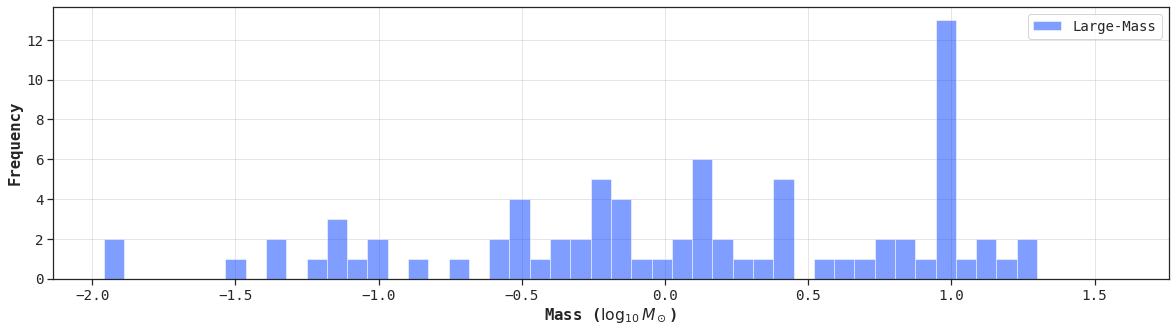

In [21]:
# Set up the figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.grid(axis='both', alpha=0.5)
# sns.color_palette("Paired")

# Choose the number of bins for the histograms
num_bins = 50

# # Plot histograms for each mass array
# ax.hist(np.log10(last_masses_array_vir), bins=num_bins, alpha=0.5, label='Virialised')
# ax.hist(np.log10(last_masses_array_cld), bins=num_bins, alpha=0.5, label='Cold-Collapse')
# ax.hist(np.log10(last_masses_array_lms), bins=num_bins, alpha=0.5, label='Large-Mass')

# Convert the mass arrays to logarithmic scale
log_last_masses_vir = np.log10(last_masses_array_vir)
log_last_masses_cld = np.log10(last_masses_array_cld)
log_last_masses_lms = np.log10(last_masses_array_lms)

# Calculate the minimum and maximum values across all three arrays
min_value = min(log_last_masses_vir.min(), log_last_masses_cld.min(), log_last_masses_lms.min())
max_value = max(log_last_masses_vir.max(), log_last_masses_cld.max(), log_last_masses_lms.max())

# Calculate the bin edges based on the combined range and number of bins
bin_edges = np.linspace(min_value, max_value, num_bins+1)

# Plot histograms for each mass array with consistent bins
# ax.hist(log_last_masses_vir, bins=bin_edges, alpha=0.5, label='Virialised')#, edgecolor = 'black')
# ax.hist(log_last_masses_cld, bins=bin_edges, alpha=0.5, label='Cold-Collapse')#, edgecolor = 'black')
ax.hist(log_last_masses_lms, bins=bin_edges, alpha=0.5, label='Large-Mass')#, edgecolor = 'black')

# Set labels and title
ax.set_xlabel('Mass ($\log_{10}{M_\odot}$)')
ax.set_ylabel('Frequency')
# ax.set_title('Distribution of Final Masses', fontsize=14)

# log scale 
# ax.set_xscale('log')

# Add a legend
ax.legend(fontsize=14)

# Show the plot
plt.show()
